# Feature Extractor
[Implementation](./featureextractor.py)
[Configuration](./FeatureExtractor.ini)

The feature extractor converts an RGB image of arbritrary size into a one-dimensional feature vector for use in a classifier. The following features are included:
- Spatial binning
- Colorspace histograms
- Histogram of gradients (hog)

## Spatial Binning
Spatial binning is done by down-sampling the image to a reduced size and converting to a one-dimensional array. For several candidate configurations a set of 200 random images from the vehicle and non-vehicle set is used and the mean/standard deviation plotted for both. From these some features are chosen randomly and plotted in a deviation plot with the goal to find a configuration where a distinct difference between vehicle and non-vehicle can be seen.

Parameters:
- sizex: Size of spatial bin in x direction
- sizey: Size of spatial bin in y direction

Configurations:
1. sizex: 32, sizey: 32
2. **sizex: 16, sizey: 16**
3. sizex: 64, sizey: 64
4. sizex: 24, sizey: 24

In general the vehicle images show much less deviation than the non-vehicle images. Changing the spatial bin does not have much impact, therefore 16x16 was chosen to have a balanced feature vector size (768) with the other features.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[spatial]
sizex = 32
sizey = 32
[hog]
pix_per_cell_x = 8
pix_per_cell_y = 8
cell_per_block_x = 2
cell_per_block_y = 2
orient = 9
[colorspace]
names = cs_HLS
[cs_HLS]
channel = H,L,S
nbins = 32
[cs_HSV]
channel = H,S,V
nbins = 32
[cs_LUV]
channel = L,U,V
nbins = 32
[cs_YUV]
channel = Y,U,V
nbins = 32
[cs_YCrCb]
channel = Y,Cr,Cb
nbins = 32
Config set: 1
Number of features: 3072


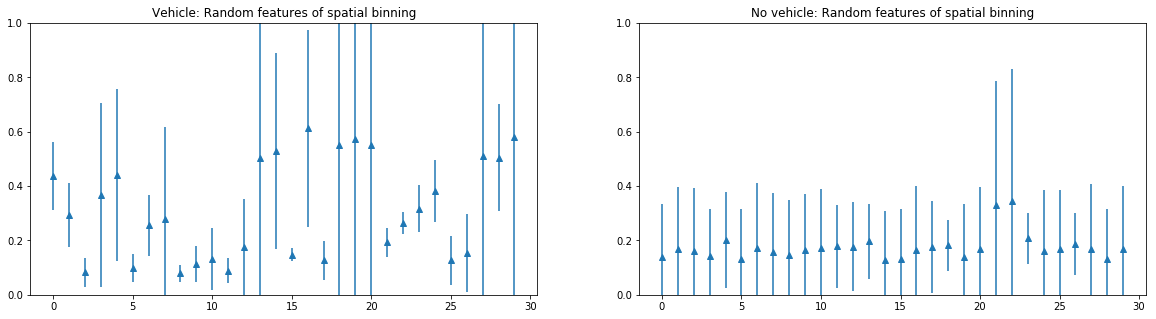

Config set: 2
Number of features: 768


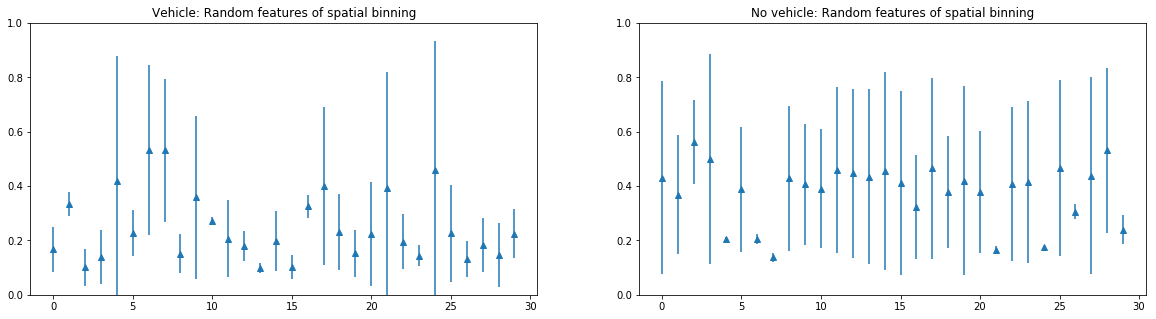

Config set: 3
Number of features: 12288


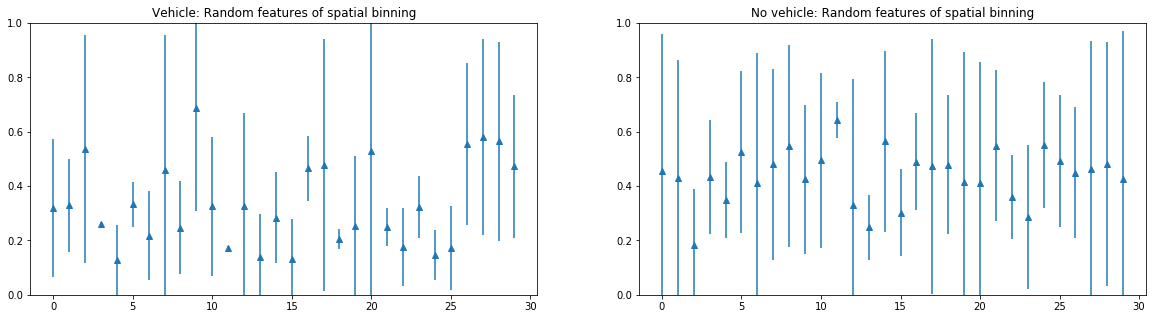

Config set: 4
Number of features: 1728


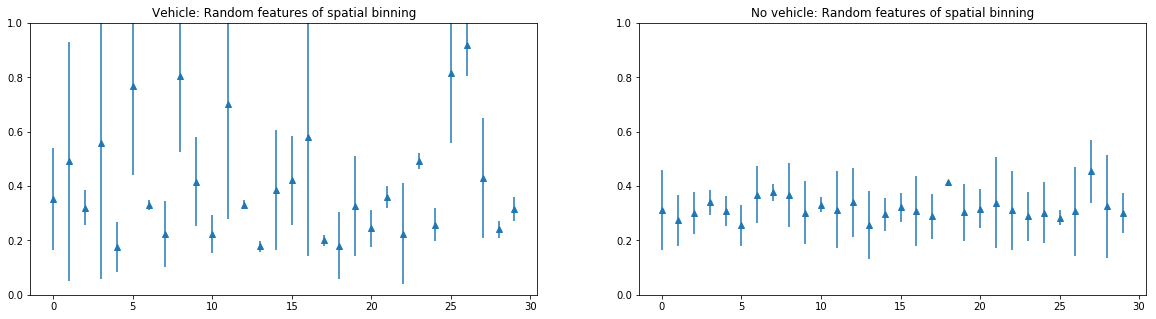

In [97]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import statistics
import numpy as np
%matplotlib inline

from images import ImageLoader
from featureextractor import FeatureExtractor

feature_extractor = FeatureExtractor()
feature_extractor.dump_config()
img_load = ImageLoader()

num_samples = 200 # Number of samples to analyze

config1 = {'spatial' : {'sizex' : '32', 'sizey' : '32'}}
config2 = {'spatial' : {'sizex' : '16', 'sizey' : '16'}}
config3 = {'spatial' : {'sizex' : '64', 'sizey' : '64'}}
config4 = {'spatial' : {'sizex' : '24', 'sizey' : '24'}}
configs = [config1, config2, config3, config4]

for cfg_idx,cfg in enumerate(configs):
    feature_extractor.set_config(cfg)
    
    feature_spatial_veh = []
    feature_spatial_nonveh = []
    for i in range(num_samples):
        # Vehicle samples
        img_veh, img_name_veh = img_load.get_random('train_vehicle')
        feature_spatial_veh.append(feature_extractor._spatial_bin(img_veh))

        # No vehicle samples
        img_nonveh, img_name_nonveh = img_load.get_random('train_non-vehicle')
        feature_spatial_nonveh.append(feature_extractor._spatial_bin(img_nonveh))

    feature_spatial_veh = np.array(feature_spatial_veh)
    feature_spatial_nonveh = np.array(feature_spatial_nonveh)

    # Get statistics from randomly selected features
    num_features = 30 # Number of features to plot
    len_features = len(feature_spatial_veh[0]) 
    mean_vehicle = []
    std_vehicle = []
    mean_novehicle = []
    std_novehicle = []
    for i in range(num_features):
        feature_idx = random.randint(0, len_features)

        # Mean and standard deviation for vehicle
        fv_list = [float(x) for x in feature_spatial_veh[:,feature_idx].tolist()]
        mean_vehicle.append(statistics.mean(fv_list))
        std_vehicle.append(statistics.stdev(fv_list))

        # Mean and standard deviation for no vehicle
        fnv_list = [float(x) for x in feature_spatial_nonveh[:,feature_idx].tolist()]
        mean_novehicle.append(statistics.mean(fnv_list))
        std_novehicle.append(statistics.stdev(fnv_list))

    # Plot statistics
    print('Config set: %d' % (cfg_idx+1) )
    print('Number of features: %d' % len_features)
    plt.figure(figsize=(20,5))

    plt.subplot(1,2,1)
    plt.errorbar(range(num_features), mean_vehicle, std_vehicle, linestyle='None', marker='^')
    plt.title('Vehicle: Random features of spatial binning')
    plt.ylim([0,1])

    plt.subplot(1,2,2)
    plt.errorbar(range(num_features), mean_novehicle, std_novehicle, linestyle='None', marker='^')
    plt.title('No vehicle: Random features of spatial binning')
    plt.ylim([0,1])

    plt.show()

## Histogram of oriented graphs
[Scikit image: Hog](http://scikit-image.org/docs/dev/api/skimage.feature.html#hog)

Parameters:
- pixels_per_cell_x: Amount of pixels in a cell along x to compute the gradient
- pixels_per_cell_y: Amount of pixels in a cell along y to compute the gradient
- cells_per_block_x: Abount of cells in a block along x
- cells_per_block_y: Abount of cells in a block along x
- orient: Number of bins

Configurations:
1. **pixels_per_cell_x/y: 8, 8, cells_per_block_x/y: 2, 2, orient: 9**
2. pixels_per_cell_x/y: 4, 4, cells_per_block_x/y: 2, 2, orient: 9
3. pixels_per_cell_x/y: 16, 16, cells_per_block_x/y: 2, 2, orient: 9
4. pixels_per_cell_x/y: 8, 8, cells_per_block_x/y: 4, 4, orient: 9
5. pixels_per_cell_x/y: 8, 8, cells_per_block_x/y: 2, 2, orient: 4

The histogram of oriented graphs is computed and visualized for some random images (vehicle and non-vehicle). By comparing them, a suitable configuration can be found. The visualization shows a very distinct difference. Especially for the config set 2 the vehicle can be easily recognized. However, due to the large amount of features (>8000) a trade-off has to be found. Therefore, the config set 1 i chosen which has 1764 features and still clearly represents the vehicle.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


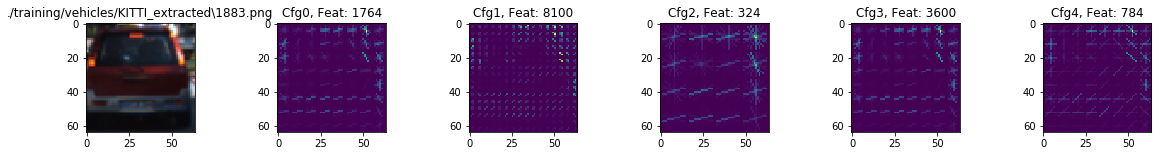

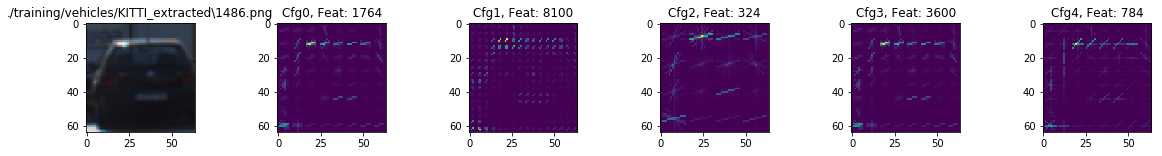

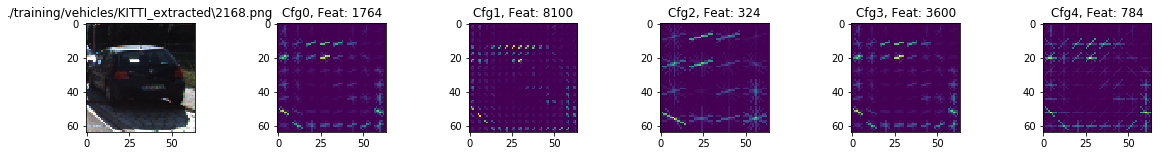

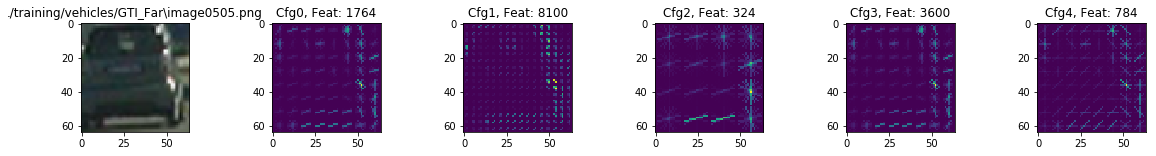

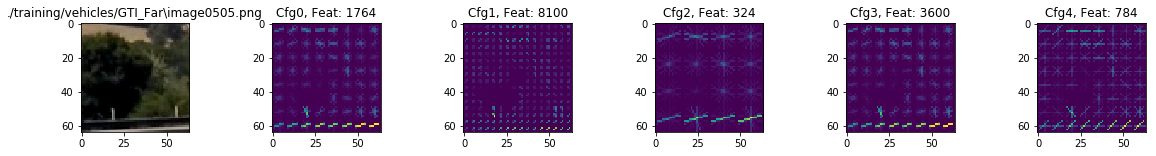

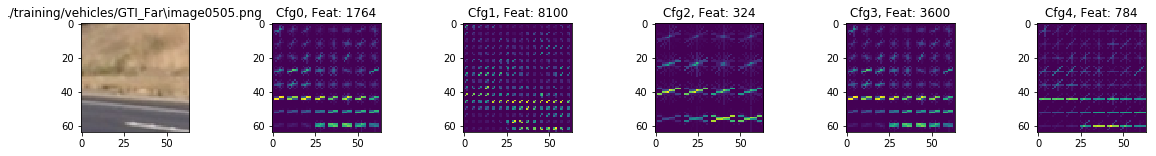

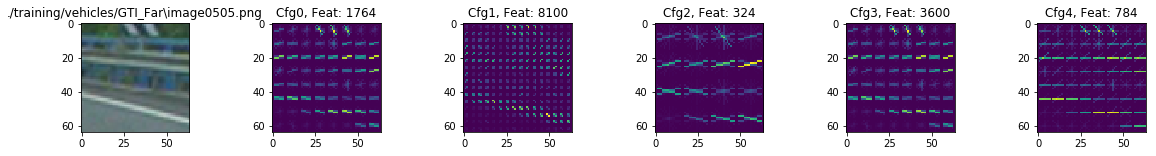

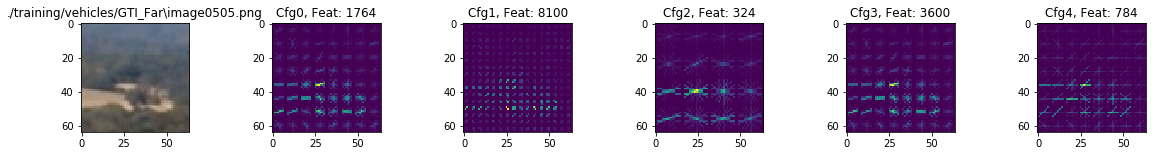

In [106]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from images import ImageLoader
from featureextractor import FeatureExtractor

feature_extractor = FeatureExtractor()
img_load = ImageLoader()

config1 = {'hog' : {'pixels_per_cell_x' : 8, 'pixels_per_cell_y' : 8, \
                    'cells_per_block_x' : 2, 'cells_per_block_y' : 2, \
                    'orient' : 9}}
config2 = {'hog' : {'pixels_per_cell_x' : 4, 'pixels_per_cell_y' : 4, \
                    'cells_per_block_x' : 2, 'cells_per_block_y' : 2, \
                    'orient' : 9}}
config3 = {'hog' : {'pixels_per_cell_x' : 16, 'pixels_per_cell_y' : 16, \
                    'cells_per_block_x' : 2, 'cells_per_block_y' : 2, \
                    'orient' : 9}}
config4 = {'hog' : {'pixels_per_cell_x' : 8, 'pixels_per_cell_y' : 8, \
                    'cells_per_block_x' : 4, 'cells_per_block_y' : 4, \
                    'orient' : 9}}
config5 = {'hog' : {'pixels_per_cell_x' : 8, 'pixels_per_cell_y' : 8, \
                    'cells_per_block_x' : 2, 'cells_per_block_y' : 2, \
                    'orient' : 4}}

configs = [config1, config2, config3, config4, config5]
num_configs = len(configs)
num_samples = 4
for i in range(num_samples):
    image_vehicle, img_name_vehicle = img_load.get_random('train_vehicle')

    plt.figure(figsize=(20,2))
    plt.subplot(1,num_configs+1,1)
    plt.title(img_name_vehicle)
    plt.imshow(image_vehicle)
    
    for i, cfg in enumerate(configs):
        feature_extractor.set_config(cfg)
        fv, hog_image = feature_extractor._hog(image_vehicle, vis=True)
        
        plt.subplot(1, num_configs+1, i+2)
        plt.title('Cfg%d, Feat: %d' % (i, len(fv)))
        plt.imshow(hog_image)
    plt.show()
    
for i in range(num_samples):    
    image_novehicle, img_name_novehicle = img_load.get_random('train_non-vehicle')
    
    plt.figure(figsize=(20,2))
    plt.subplot(1,num_configs+1,1)
    plt.title(img_name_vehicle)
    plt.imshow(image_novehicle)
    
    for i, cfg in enumerate(configs):
        feature_extractor.set_config(cfg)
        fv, hog_image = feature_extractor._hog(image_novehicle, vis=True)
        
        plt.subplot(1, num_configs+1, i+2)
        plt.title('Cfg%d, Feat: %d' % (i, len(fv)))
        plt.imshow(hog_image)
    plt.show()

## Color space
### Parameters:
### Configurations:
To chose a suitable colorspace for histogram features a set of random samples (200) is used to calculate mean and std in all colorspaces and channels. By visualizing and comparing them the channels with the most distinct differences between vehicle and non-vehicle are chosen (e.g. large mean in vehicle should show a small mean in non-vehicle).

Parameters:
- names: Defines which colorspace shall be used
- channel: Defines which channel of the colorspace shall be used
- nbins: Defines how many histogram bins shall be used

Configurations:
1. HLS, all channels, nbins = 32
2. HSV, all channels, nbins = 32
3. LUV, all channels, nbins = 32
4. YUV, all channels, nbins = 32
5. YCrCb, all channels, nbins = 32

The channels we are interested in are the ones, where the vehicle and non-vehicle histograms are as different as possible. For comparison the normalized features are also include, since these will be used by the classifer. The most promising channels were determined as:
- **L from HLS**
- **U from YUV**
- **Y from YCrCb**

With these the 6. config set is set up and included as last plot. Since the number of features was quite small, but the difference quite distinct the number of bins was also increased to 64. In the normalized histogramm a clear seperation from vehicle and non-vehicle can be found in these channels.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Config set: 1
Colorspace: cs_HLS
Number of features: 96


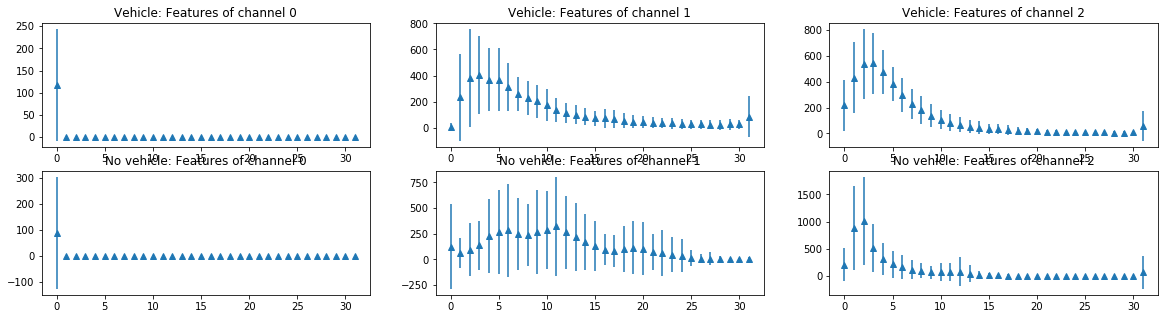

Scaled


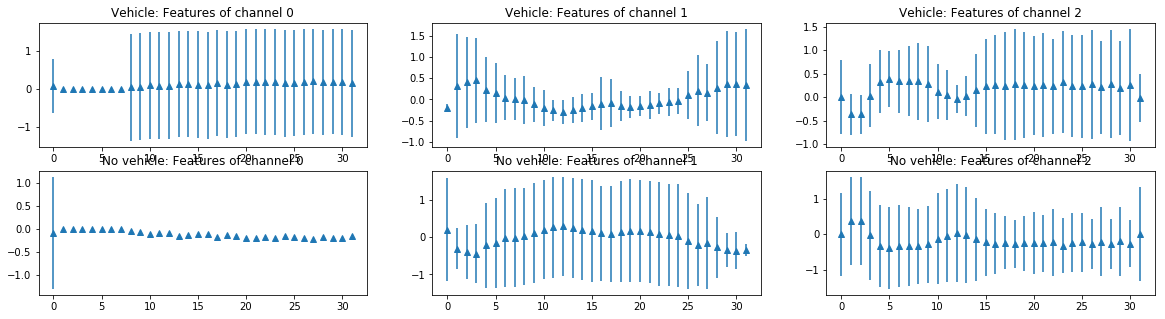

Config set: 2
Colorspace: cs_HSV
Number of features: 96


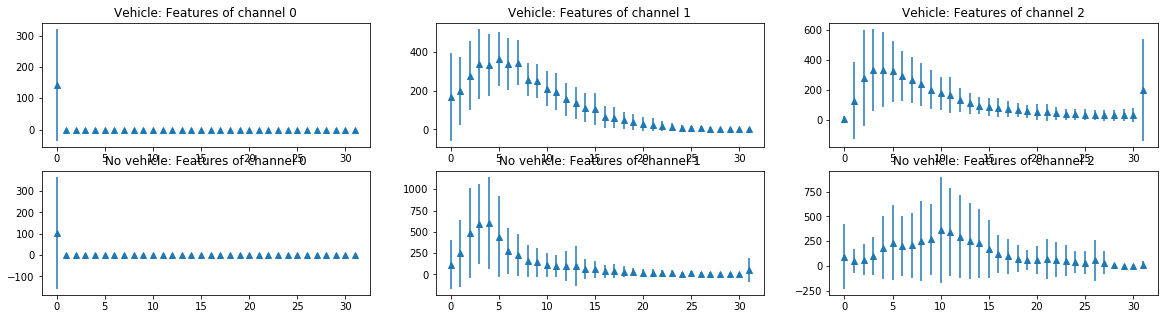

Scaled


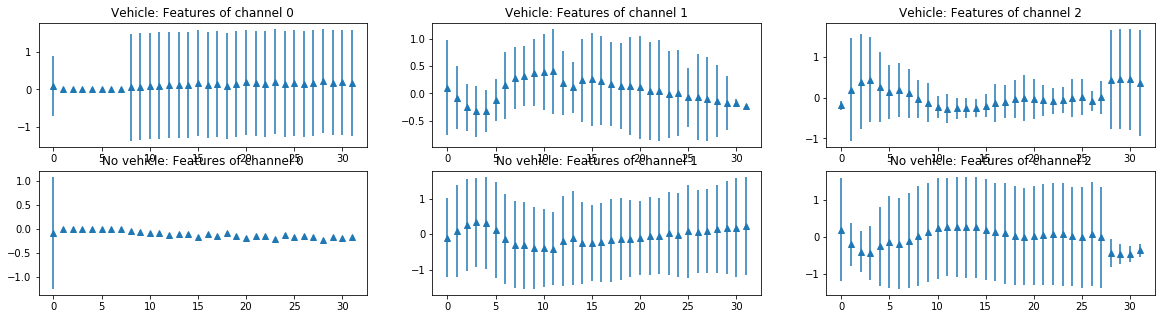

Config set: 3
Colorspace: cs_LUV
Number of features: 96


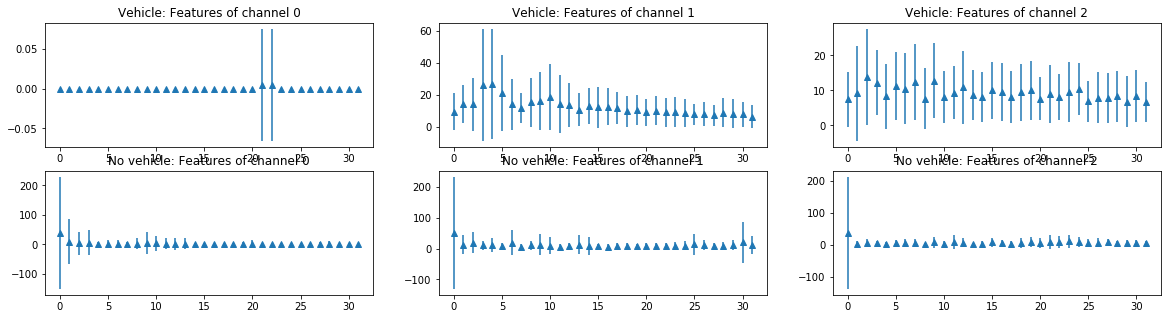

Scaled


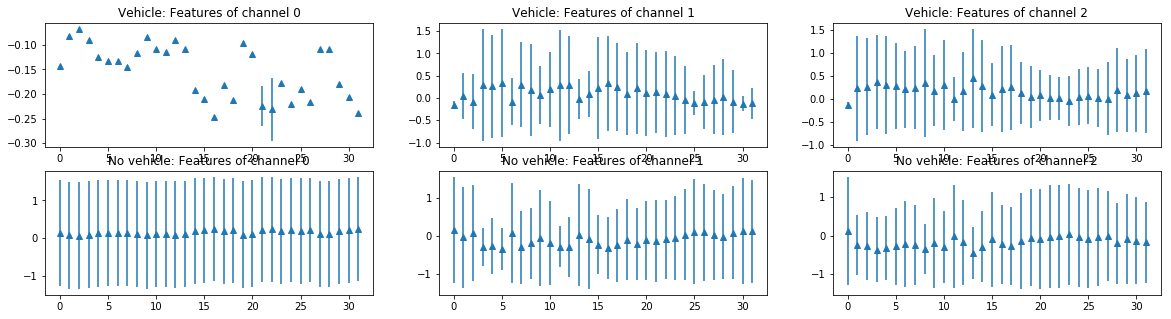

Config set: 4
Colorspace: cs_YUV
Number of features: 96


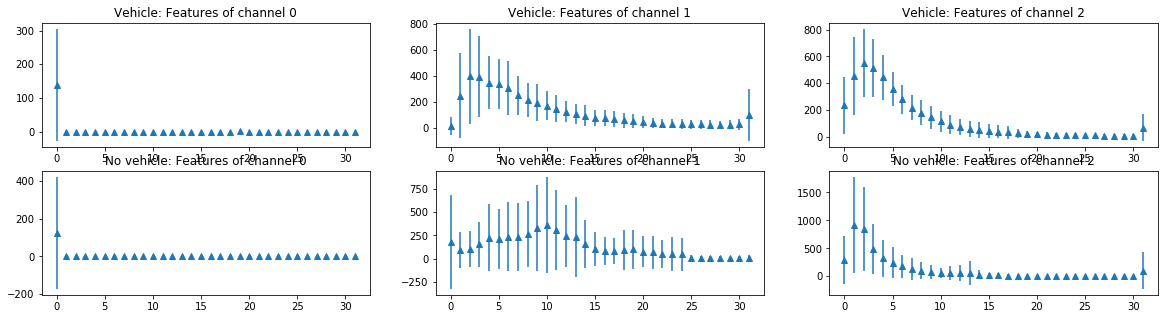

Scaled


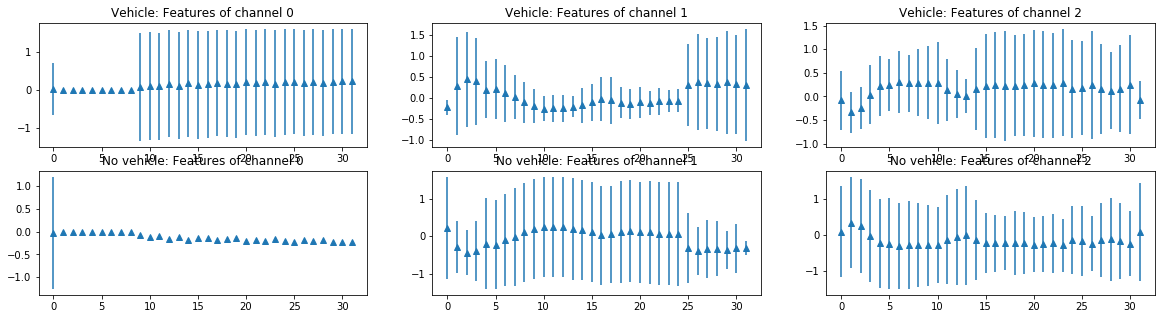

Config set: 5
Colorspace: cs_YCrCb
Number of features: 96


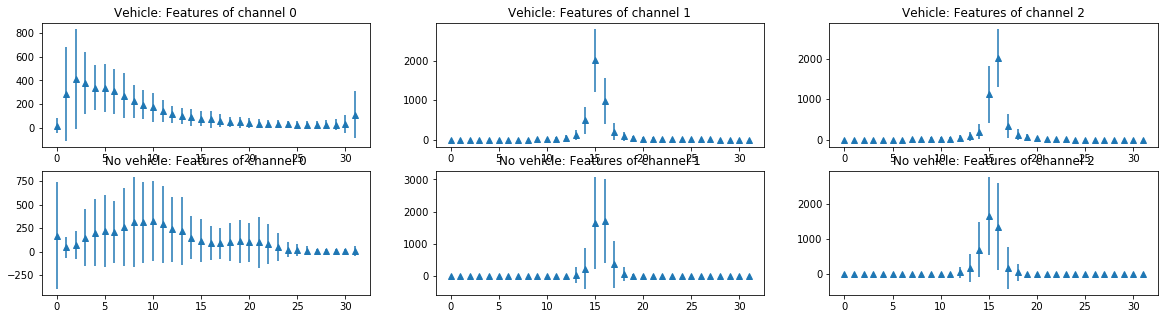

Scaled


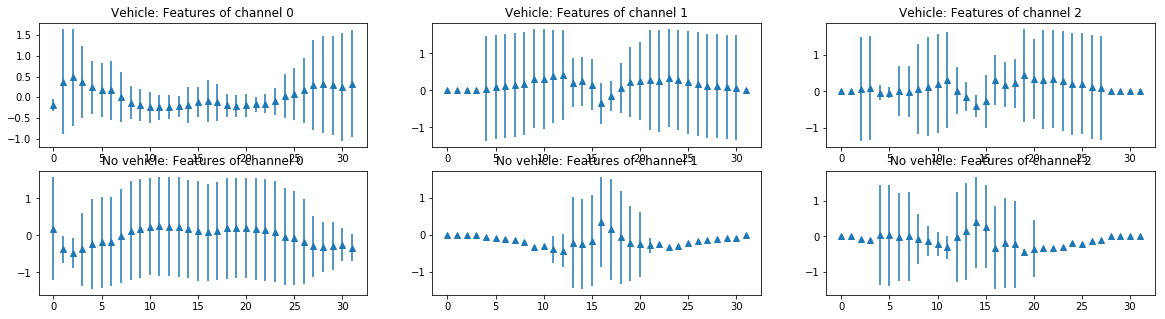

Config set: 6
Colorspace: cs_HLS,cs_YUV,cs_YCrCb
Number of features: 192


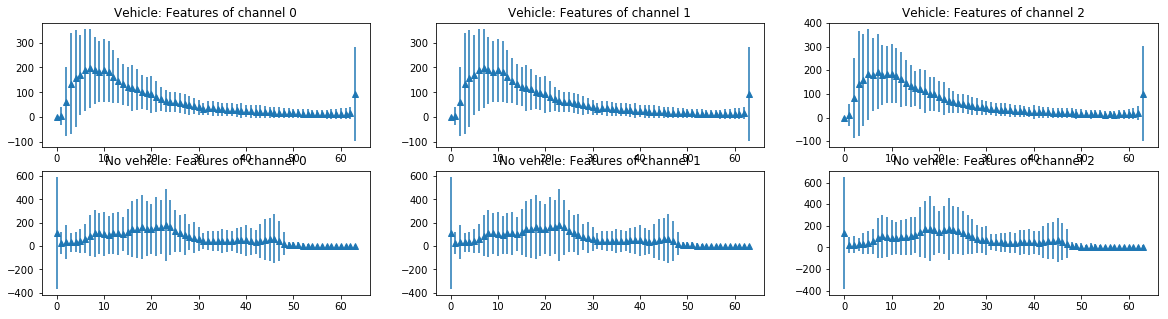

Scaled


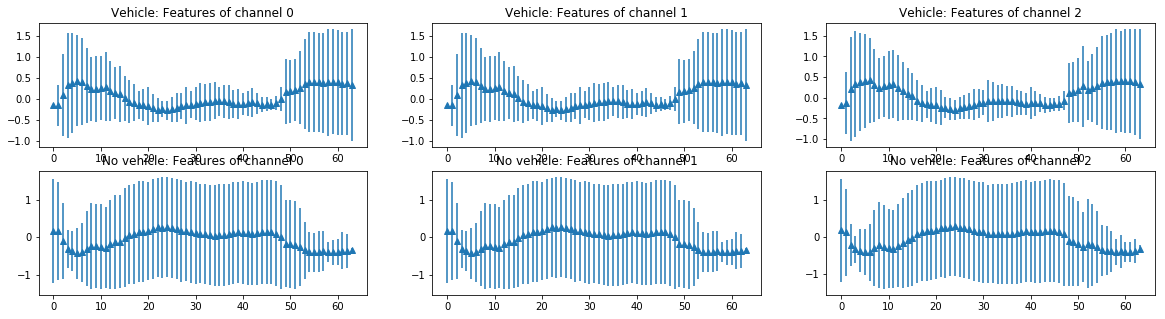

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import statistics
import numpy as np
from sklearn.preprocessing import StandardScaler
%matplotlib inline

from images import ImageLoader
from featureextractor import FeatureExtractor

feature_extractor = FeatureExtractor()
img_load = ImageLoader()

num_samples = 200 # Number of samples to analyze

config1 = {'colorspace' : {'names' : 'cs_HLS'}, 'cs_HLS' : {'channel' : 'H,L,S', 'nbins' : '32'}}
config2 = {'colorspace' : {'names' : 'cs_HSV'}, 'cs_HSV' : {'channel' : 'H,S,V', 'nbins' : '32'}}
config3 = {'colorspace' : {'names' : 'cs_LUV'}, 'cs_LUV' : {'channel' : 'L,U,V', 'nbins' : '32'}}
config4 = {'colorspace' : {'names' : 'cs_YUV'}, 'cs_YUV' : {'channel' : 'Y,U,V', 'nbins' : '32'}}
config5 = {'colorspace' : {'names' : 'cs_YCrCb'}, 'cs_YCrCb' : {'channel' : 'Y,Cr,Cb', 'nbins' : '32'}}

config6 = {'colorspace' : {'names' : 'cs_HLS,cs_YUV,cs_YCrCb'}, 
           'cs_HLS' : {'channel' : 'L', 'nbins' : '64'},
           'cs_YUV' : {'channel' : 'U', 'nbins' : '64'},
           'cs_YCrCb' : {'channel' : 'Y', 'nbins' : '64'},
          }
configs = [config1, config2, config3, config4, config5, config6]
num_channels = [3, 3, 3, 3, 3, 3]

for cfg_idx,cfg in enumerate(configs):
    feature_extractor.set_config(cfg)
    
    feature_cs_veh = []
    feature_cs_nonveh = []
    for i in range(num_samples):
        # Vehicle samples
        img_veh, img_name_veh = img_load.get_random('train_vehicle')
        feature_cs_veh.append(feature_extractor._color_space(img_veh))

        # No vehicle samples
        img_nonveh, img_name_nonveh = img_load.get_random('train_non-vehicle')
        feature_cs_nonveh.append(feature_extractor._color_space(img_nonveh))

    feature_cs_veh = np.array(feature_cs_veh)
    feature_cs_nonveh = np.array(feature_cs_nonveh)
    feature_cs_all = np.vstack((feature_cs_veh, feature_cs_nonveh)).astype(np.float64) 
    
    len_features = len(feature_cs_veh[0])
    
    mean_vehicle = []
    std_vehicle = []
    scaled_mean_vehicle = []
    scaled_std_vehicle = []
    
    mean_novehicle = []
    std_novehicle = []
    scaled_mean_novehicle = []
    scaled_std_novehicle = []
    
    # Normalize feature vectors
    X_scaler = StandardScaler().fit(feature_cs_all)
    # Apply the scaler to X
    scaled_feature_cs_veh = X_scaler.transform(feature_cs_veh.astype(np.float64))
    scaled_feature_cs_nonveh = X_scaler.transform(feature_cs_nonveh.astype(np.float64))
    
    for feature_idx in range(len_features):
        # Mean and standard deviation for vehicle
        fv_list = [float(x) for x in feature_cs_veh[:,feature_idx].tolist()]
        mean_vehicle.append(statistics.mean(fv_list))
        std_vehicle.append(statistics.stdev(fv_list))
        
        scaled_fv_list = [float(x) for x in scaled_feature_cs_veh[:,feature_idx].tolist()]
        scaled_mean_vehicle.append(statistics.mean(scaled_fv_list))
        scaled_std_vehicle.append(statistics.stdev(scaled_fv_list))

        # Mean and standard deviation for no vehicle
        fnv_list = [float(x) for x in feature_cs_nonveh[:,feature_idx].tolist()]
        mean_novehicle.append(statistics.mean(fnv_list))
        std_novehicle.append(statistics.stdev(fnv_list))
        
        scaled_fnv_list = [float(x) for x in scaled_feature_cs_nonveh[:,feature_idx].tolist()]
        scaled_mean_novehicle.append(statistics.mean(scaled_fnv_list))
        scaled_std_novehicle.append(statistics.stdev(scaled_fnv_list))
    
    # Plot statistics
    print('Config set: %d' % (cfg_idx+1))
    print('Colorspace: %s' % cfg['colorspace']['names'])
    print('Number of features: %d' % len_features)
    plt.figure(figsize=(20,5))
    nc = num_channels[cfg_idx]
    for idx_ch in range(0,nc):
        x = range(int(len_features/nc))

        y = np.split(np.array(mean_vehicle),nc)[idx_ch]
        y_std = np.split(np.array(std_vehicle),nc)[idx_ch]
        plt.subplot(2,nc,1+idx_ch)    
        plt.errorbar(x, y, y_std, linestyle='None', marker='^')
        plt.title('Vehicle: Features of channel %d' % idx_ch)
        
        y = np.split(np.array(mean_novehicle),nc)[idx_ch]
        y_std = np.split(np.array(std_novehicle),nc)[idx_ch]
        plt.subplot(2,nc,nc+1+idx_ch)
        plt.errorbar(x, y, y_std, linestyle='None', marker='^')
        plt.title('No vehicle: Features of channel %d' % idx_ch)
    
    plt.show()

    print('Scaled')
    plt.figure(figsize=(20,5))
    for idx_ch in range(0,nc): 
        x = range(int(len_features/nc))
        
        y = np.split(np.array(scaled_mean_vehicle),nc)[idx_ch]
        y_std = np.split(np.array(scaled_std_vehicle),nc)[idx_ch]
        plt.subplot(2,nc,1+idx_ch)
        plt.errorbar(x, y, y_std, linestyle='None', marker='^')
        plt.title('Vehicle: Features of channel %d' % idx_ch)
        
        y = np.split(np.array(scaled_mean_novehicle),nc)[idx_ch]
        y_std = np.split(np.array(scaled_std_novehicle),nc)[idx_ch]
        plt.subplot(2,nc,nc+1+idx_ch)
        plt.errorbar(x, y, y_std, linestyle='None', marker='^')
        plt.title('No vehicle: Features of channel %d' % idx_ch)
    
    plt.show()

## Save config
The final configuration is saved in the .ini file for later use in the downstream pipeline.

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

from featureextractor import FeatureExtractor

feature_extractor = FeatureExtractor()

final_config = {}
final_config['spatial'] = {'sizex' : '16', 'sizey' : '16'}
final_config['hog'] = {'pixels_per_cell_x' : 8, 'pixels_per_cell_y' : 8,
                       'cells_per_block_x' : 2, 'cells_per_block_y' : 2,
                       'orient' : 9}
final_config['colorspace'] = {'names' : 'cs_HLS,cs_YUV,cs_YCrCb'}
final_config['cs_HLS'] = {'channel' : 'L', 'nbins' : '64'}
final_config['cs_YUV'] = {'channel' : 'U', 'nbins' : '64'}
final_config['cs_YCrCb'] = {'channel' : 'Y', 'nbins' : '64'}

feature_extractor.set_config(final_config)
feature_extractor.write_config()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## Full feature vector
To wrap it all up a full feature vector with all 3 features is calculated. Some benchmarking is included to see where optimization can be done (mostly in hog and histograms).
The full feature vector has a length of 2724, which seems like a good starting point for the classifier:
- 764 for spatial bin
- 1764 for hog
- 192 for histogram

In [4]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

import matplotlib.pyplot as plt
import statistics
import numpy as np
%matplotlib inline

from images import ImageLoader
from featureextractor import FeatureExtractor

feature_extractor = FeatureExtractor()
feature_extractor.dump_config()

img_load = ImageLoader()

image_vehicle,_ = img_load.get_random('train_vehicle')
feature_vector = feature_extractor.feature_vector(image_vehicle)
print('Feature vector length: %d' %len(feature_vector))

def benchmark(n):
    for i in range(n):
        image_vehicle,_ = img_load.get_random('train_vehicle')
        feature_vector = feature_extractor.feature_vector(image_vehicle)
        
%time benchmark(100)
%lprun -f feature_extractor.feature_vector benchmark(1)
print('Done')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
[spatial]
sizex = 16
sizey = 16
[hog]
pixels_per_cell_x = 8
pixels_per_cell_y = 8
cells_per_block_x = 2
cells_per_block_y = 2
orient = 9
[colorspace]
names = cs_HLS,cs_YUV,cs_YCrCb
[cs_HLS]
channel = L
nbins = 64
[cs_HSV]
channel = H,S,V
nbins = 64
[cs_LUV]
channel = U
nbins = 64
[cs_YUV]
channel = U
nbins = 64
[cs_YCrCb]
channel = Y
nbins = 64
Feature vector length: 2724
Wall time: 8.33 s
Done
